# Plot $R_0$ dependence on specific humidity and data in Australia
## From MERRA-2/SIRS model
* HCoV-HKU1 parameters
* weekly resolution
* monthly ENSO composites => Oct-Nov-Dec average (OND)

Last updated August 22 2024

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
# climate dependence parameters for HCoV-HKU1 (human coronavirus)

climdepens ={
    'HKU1': dict(a=-227.5, R0_min=1.5, R0_max=2.5)}

def q2R0(q, a, R0_min, R0_max):
    '''R0 dependence on climate (specific humidity)'''
    R0 = (R0_max - R0_min) * np.exp(a*q) + R0_min
    if isinstance(R0, xr.DataArray):
        R0.name = 'R0'
    
    return R0

# Plot specific humidity and $R_0$ El Niño anomaly

In [3]:
# select australia only

def get_Australia(ds):
    # 110-155E
    # 10-45S
    return ds.sel(longitude = slice(110,155), latitude = slice(-45,-8))

def get_monthlydata(ds):
    return ds.resample(time="M").mean(dim='time')

def get_ENSOyrs():
    import pandas as pd
    # import ENSO years 
    df=pd.read_csv('./ENSO_yrs_final.csv', index_col=0)
    ds = df.to_xarray()
    # Convert the array to boolean array
    ds = ds.astype(bool)
    return ds

def ENSO_comp(HKU1, comp_types):
    
    ENSOds = get_ENSOyrs()
    from tqdm.notebook import tqdm
    
    comp_ds = xr.Dataset()
    
    for ii in tqdm(range(np.size(comp_types))):

        composite_type = comp_types[ii]

        # get event years
        event_years = ENSOds.year[ENSOds[composite_type]]

        # get years from data.TIME
        years_array = pd.DatetimeIndex(HKU1.time).year

        # for each year in the list, find the events_all from that year
        included_bool_array = [year in event_years for year in years_array]

        # get all the events from the data
        events_all = HKU1.isel(time=included_bool_array)

        # put into year/month format
        for ii in range(event_years.size):
            # get data from that year
            data_monthly = events_all.isel(time=slice(ii*12,ii*12+12))
            #print(data_temp)

            data_monthly = data_monthly.rename({'time': 'month'})
            data_monthly['month'] = np.arange(1, 13)

            data_monthly = data_monthly.assign_coords(year=event_years[ii])

            if ii == 0:
                events_yearmonth = data_monthly
            else:
                events_yearmonth = xr.concat([events_yearmonth,data_monthly], dim='year')

        # compute composite
        comp = events_yearmonth.mean('year')
        
        comp_ds[composite_type] = comp
    

    return comp_ds
        #events_yearmonth.to_netcdf(f"./data_{res}/ENSO_HKU1_{composite_type}_allevents.nc")
        #comp.to_netcdf(f"./data_{res}/ENSO_HKU1_{composite_type}_composite.nc")



In [4]:
# load q data
q = xr.open_dataarray('./SIRSmodel_input/MERRA2.1981-2017.QV2M.weekly.nc')
q = get_Australia(q)
q

<xarray.DataArray 'QV2M' (time: 13508, latitude: 75, longitude: 73)>
[73956300 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1981-01-04T12:00:00 ... 2017-12-28T12:00:00
  * longitude  (longitude) float64 110.0 110.6 111.2 111.9 ... 153.8 154.4 155.0
  * latitude   (latitude) float64 -45.0 -44.5 -44.0 -43.5 ... -9.0 -8.5 -8.0
Attributes:
    standard_name:   2-meter_specific_humidity
    long_name:       2-meter_specific_humidity
    units:           kg kg-1
    fmissing_value:  1000000000000000.0
    vmax:            1000000000000000.0
    vmin:            -1000000000000000.0

In [5]:
# load R0 data
R0 = xr.open_dataarray('./SIRSmodel_input/HKU1_MERRA2_weekly_R0.nc')
R0 = get_Australia(R0)

In [6]:
# get monthly data
q_mm = get_monthlydata(q)
R0_mm = get_monthlydata(R0)

In [7]:
# compute climatology
clim_q = q_mm.groupby('time.month').mean('time')
clim_R0 = R0_mm.groupby('time.month').mean('time')

In [8]:
# compute ENSO composites
import pandas as pd
comp_q = ENSO_comp(q_mm,['ElNino','LaNina'])
comp_R0 = ENSO_comp(R0_mm,['ElNino','LaNina'])

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
comp_q

<xarray.Dataset>
Dimensions:    (longitude: 73, latitude: 75, month: 12)
Coordinates:
  * longitude  (longitude) float64 110.0 110.6 111.2 111.9 ... 153.8 154.4 155.0
  * latitude   (latitude) float64 -45.0 -44.5 -44.0 -43.5 ... -9.0 -8.5 -8.0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    ElNino     (month, latitude, longitude) float32 0.006581 0.006599 ... 0.019
    LaNina     (month, latitude, longitude) float32 0.006493 ... 0.01932

## Plot

In [10]:
q_arr = np.arange(0.0001,0.02,0.001)
R0_HKU1 = q2R0(q_arr, **climdepens['HKU1'])

Text(0.66, 0.95, 'El Niño anomaly (Year 0, OND)')

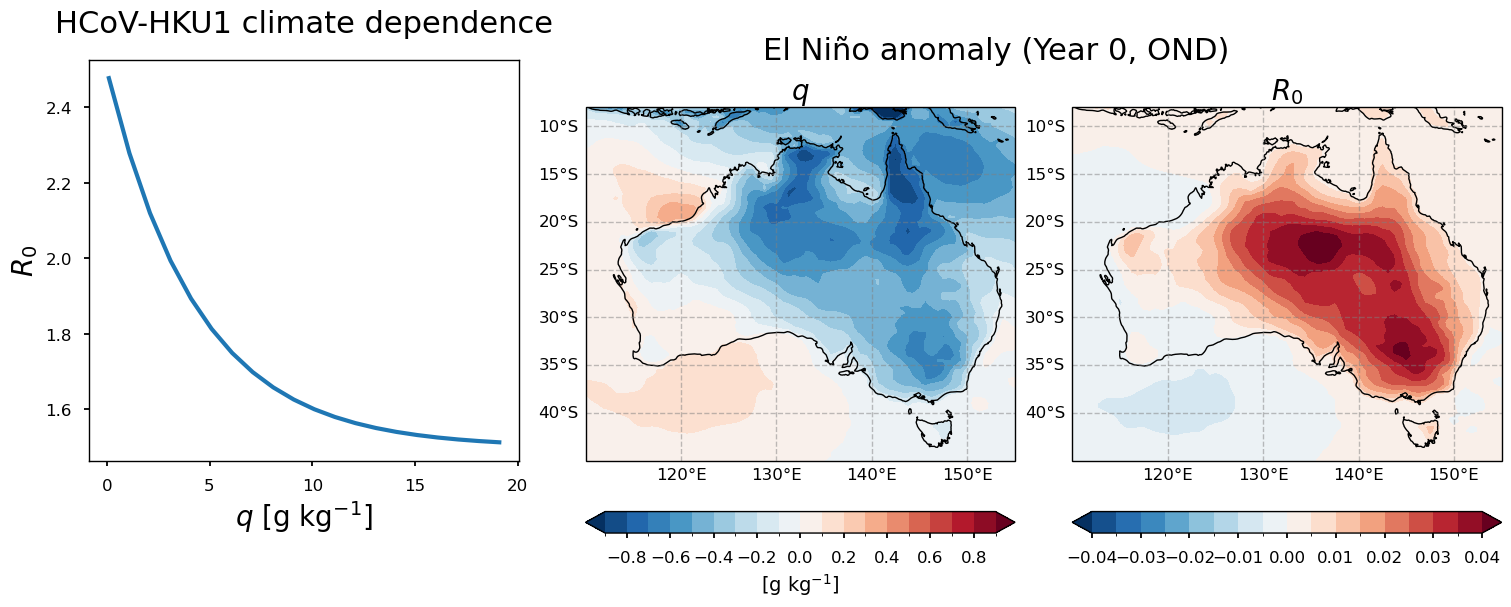

In [16]:
plt.style.use('/tigress/mvchung/ANALYSIS/func/PPT.mplstyle')

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig, ax = plt.subplots(1, 3, figsize=(15, 6), constrained_layout=True)
ax[1].axis("off")
ax[2].axis("off")

# First subplot (standard plot)
ax[0] = plt.subplot(1, 3, 1)
ax[0].plot(q_arr * 1000, R0_HKU1, label='HKU1', linewidth=3)
ax[0].set_xlabel('$q$ [g kg$^{-1}$]', fontsize=20)
ax[0].set_ylabel('$R_0$', fontsize=20)#, rotation=0, labelpad=15)
#ax[0].set_title('', fontsize=22, pad=70, y=0.95)
ax[0].set_title('HCoV-HKU1 climate dependence', fontsize=22, pad=20)


# Second subplot with PlateCarree projection
ax[1] = plt.subplot(1, 3, 2, projection=ccrs.PlateCarree())
q_anom = comp_q['ElNino'].sel(month=slice(10,12)).mean('month') - clim_q.sel(month=slice(10,12)).mean('month')
cf = (1000*q_anom).plot.contourf(ax=ax[1], cmap='RdBu_r', 
                     transform=ccrs.PlateCarree(), levels=np.arange(-0.9,1,0.1), extend='both')
ax[1].set_title('$q$', fontsize=20)
ax[1].coastlines()
gridlines = ax[1].gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5)
gridlines.top_labels = False  # Hide top x-axis labels
gridlines.right_labels = False  # Hide right y-axis labels
cf.colorbar.remove()
cb = fig.colorbar(cf,ax=ax[1], orientation='horizontal', pad=-0.05)
cb.set_label('[g kg$^{-1}$]')

# Third subplot with PlateCarree projection
ax[2] = plt.subplot(1, 3, 3, projection=ccrs.PlateCarree())
R0_anom = comp_R0['ElNino'].sel(month=slice(10,12)).mean('month') - clim_R0.sel(month=slice(10,12)).mean('month')
cf = R0_anom.plot.contourf(ax=ax[2], cmap='RdBu_r',
                      transform=ccrs.PlateCarree(), levels=np.arange(-0.04,0.045,0.005), extend='both')
ax[2].set_title('$R_0$', fontsize=20)
ax[2].coastlines()
gridlines = ax[2].gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5)
gridlines.top_labels = False  # Hide top x-axis labels
gridlines.right_labels = False  # Hide right y-axis labels
cf.colorbar.remove()
fig.colorbar(cf,ax=ax[2], orientation='horizontal', pad=-0.05)

fig.suptitle('El Niño anomaly (Year 0, OND)', x=0.66, y=0.95, fontsize=22)